In [1]:
from fractions import Fraction
import numpy as np
import math
import matplotlib.pyplot as plt
from typing import *

import qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
sim = AerSimulator()

from util import zero, one, qpe, qft_dagger, amod15, factor2_to_order

# Shor's Part 5/5: Shor's Algorithm with Quantum Order Finding

In this notebook, we'll put together all the building blocks we have seen previously to implement Shor's algorithm. Shor's algorithm consists of
1. **quantum order finding** and
2. a continued fraction algorithm.
We'll focus on quantum order finding since it is the interesting quantum part of the algorithm.

References
1. [Introduction to Classical and Quantum Computing, Chapter 7.7](https://www.thomaswong.net/introduction-to-classical-and-quantum-computing-1e4p.pdf)
2. [Qiskit notebook on Shor's algorithm](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/shor.ipynb)
3. [Qiskit notebook on QFT](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/quantum-fourier-transform.ipynb)
4. [Introduction to Quantum Information Science: Lectures 19 and 20 by Scott Aaronson](https://www.scottaaronson.com/qclec.pdf)
5. [Quantum Computation and Quantum Information: Chapter 5, Nielsen and Chuang](https://www.cambridge.org/highereducation/books/quantum-computation-and-quantum-information/01E10196D0A682A6AEFFEA52D53BE9AE#overview)

## Order Finding

We'll review classical order finding and probabilistic order finding to illustrate the difficulty of order finding with classical computation. We'll then introduce quantum order finding.

## Classical Order Finding

Reminder: the goal is to find the order of a given $a$ and $N$, i.e., the smallest $s$ such that

$$
a^s \, (\text{mod} \, N) \equiv 1 \,.
$$

Text(0.5, 1.0, 'a=7 and N=15')

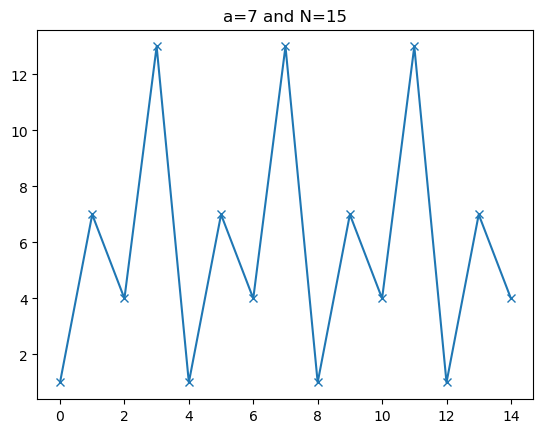

In [2]:
a = 7
N = 15
xs = [x for x in range(N)]
ys = [(a ** x) % N for x in xs]
plt.plot(xs, ys, marker="x")
plt.title("a=7 and N=15")

### Deterministic algorithm

We can just enumerate ...

In [3]:
def order_find_det(a: int, N: int) -> int:
    s = 1
    while True:
        if (a ** s) % N == 1:
            return s
        s += 1

In [4]:
order_find_det(7, 15)

4

## Probabilistic Order Finding

1. Let's use the period finding formulation of order finding for $a$ and $N$ as $f(x) = a^x \, (\text{mod} \, N)$.
2. Suppose we random sample numbers $x$ and $y$ and check if $f(x) = f(y)$.
3. Since we have a periodic function with period $s$, there are only $s$ distinct values that $f$ can take on.
4. How many $x$'s do we need to check before we find a collision?

### Aside: Birthday paradox

We require 23 people ($\approx \sqrt{365}$) before we find 2 people with the same birthday with probability at least 50%.

See [https://en.wikipedia.org/wiki/Birthday_problem](https://en.wikipedia.org/wiki/Birthday_problem)

In [5]:
count_collision = 0
for i in range(1000):
    if len(np.unique(np.random.choice(np.arange(365), size=23))) != 23:
        count_collision += 1
print("Probability of same birthday", count_collision/1000)

Probability of same birthday 0.503


### Returning to Probabilistic algorithm

1. Sample approximately $\sqrt{s}$ to find a collision with probability 50%, i.e., an $x$ and $y$ such that $f(x) = f(y)$.
2. Without loss of generality, assume that $y > x$.
3. We know that $s | y - x$ so that we can determine $s$ with high probability if we find a few more collisions and compute the $\text{gcd}(y_1 - x_1, y_2 - x_2, y_3 - x_3, \dots)$.

In [6]:
def order_find_prob(f: Callable, N: int, k: int = 4) -> int:
    def go():
        found = set()
        found.add(f(0))
        mapping = {f(0): 0}
        while True:
            x = np.random.choice(np.arange(N))
            fx = f(x)
            if fx in found:
                return min(x, mapping[fx]), max(x, mapping[fx])
            mapping[fx] = x
            found.add(fx)
    diffs = []
    for i in range(k):
        x, y = go()
        diffs += [y - x]
    return math.gcd(*diffs)

(array([93.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  7.]),
 array([4. , 4.4, 4.8, 5.2, 5.6, 6. , 6.4, 6.8, 7.2, 7.6, 8. ]),
 <BarContainer object of 10 artists>)

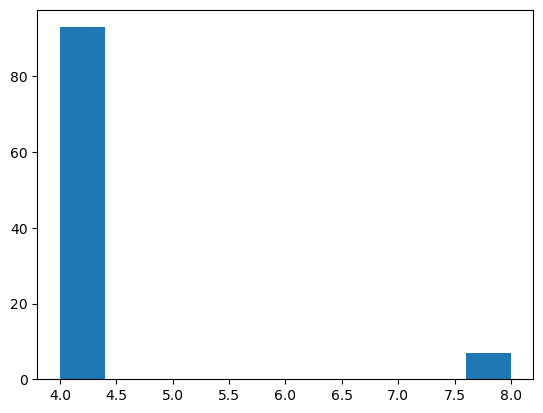

In [7]:
ans = []
for i in range(100):
    ans += [order_find_prob(lambda x: (7 ** x) % 15, 15, k=4)]
plt.hist(ans)

#### Analysis

1. If $s = 2^n$, then we require $\sqrt{s} = 2^{n/2}$ queries.
2. For example, if $n = 2056$, then we still require $2^{1024}$ queries.
3. This is why RSA depends on large primes so that $s$ is large.
4. In particular, since $s | \phi(N)$ then either $s | (p - 1)$ or $s | (q - 1)$.

## Quantum Order Finding

The quantum order finding algorithm
1. uses QPE to estimate the phase of $U$ and 
2. followed by a **continued fractions** algorithm to extra the order from the phase.

### Step 1: QPE

In [8]:
def qpe_amodN(a: int, amodN: Callable, n_count: int) -> float:
    # Construct circuit
    qc = qpe(lambda q: amodN(a, q), n_count)    
    
    # Transplile away custom circuit
    t_qc = transpile(qc, sim)
    
    # Simulate
    # Setting memory=True below allows us to see a list of each sequential reading
    result = sim.run(t_qc, shots=1, memory=True).result()
    readings = result.get_memory()

    # Get phase
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase

In [9]:
n_count = 8
N = 15
a = 7
phase = qpe_amodN(a, amod15, n_count)
phase

Register Reading: 00110100
Corresponding Phase: 0.203125


0.203125

### Step 2: Continued Fractions Algorithm

In [10]:
Fraction(phase).limit_denominator(N)

Fraction(1, 5)

### Putting it together

In [11]:
def order_find_quantum(a: int, N: int, amodN: Callable, n_count: int) -> int:
    # Step 1: Perform QPE to get phase = \ell/s
    phase = qpe_amodN(a, amodN, n_count)
    
    # Step 2: Perform continued fractions algorithm to extract order
    frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
    s = frac.denominator
    
    return s

## Shor's Algorithm

1. Apply quantum phase estimation to learn phase of $U_f$.
2. Apply **continued fractions** algorithm to extract order from phase.
3. Apply factoring to order finding reduction.

In [12]:
def shors_algorithm(a: int, N: int, n_count: int) -> None:
    attempt = 0
    while True:
        attempt += 1
        print("\nAttempt %i:" % attempt)

        # Step 1: Perform quantum order finding
        if N == 15:
            s = order_find_quantum(a, N, amod15, n_count)
        else:
            raise ValueError(f"Oracle not implemented for N = {N}")
        print("Result: s = %i" % s)

        # Step 2: Solve factor in terms of order finding
        if phase != 0:
            maybe_guess = factor2_to_order(N, a, s)
            if maybe_guess is not None:
                print("*** Non-trivial factor found: %i ***" % maybe_guess)
                break

In [13]:
n_count = 8
N = 15
a = 7
shors_algorithm(a, N, n_count)


Attempt 1:
Register Reading: 00111100
Corresponding Phase: 0.234375
Result: s = 13
13

Attempt 2:
Register Reading: 01100100
Corresponding Phase: 0.390625
Result: s = 13
13

Attempt 3:
Register Reading: 01101000
Corresponding Phase: 0.406250
Result: s = 5
5

Attempt 4:
Register Reading: 10001100
Corresponding Phase: 0.546875
Result: s = 11
11

Attempt 5:
Register Reading: 10001100
Corresponding Phase: 0.546875
Result: s = 11
11

Attempt 6:
Register Reading: 01000100
Corresponding Phase: 0.265625
Result: s = 15
15

Attempt 7:
Register Reading: 10101000
Corresponding Phase: 0.656250
Result: s = 3
3

Attempt 8:
Register Reading: 01011000
Corresponding Phase: 0.343750
Result: s = 3
3

Attempt 9:
Register Reading: 10110000
Corresponding Phase: 0.687500
Result: s = 13
13

Attempt 10:
Register Reading: 01101100
Corresponding Phase: 0.421875
Result: s = 12
*** Non-trivial factor found: 3 ***
